In [2]:
#Project Developed by 
# Muhammad Usama Saleem, 19I-1901

# Dataset used: fruits_360 from kaggle datasets repository

# Instructions to run the model

# The datasset is available on kaggle thus the model can be easily trained there with the required dataset. To run the model,
# make sure the GPU is enabled because all of the code can only be compiled using GPU.

In [20]:
#Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Importing NN libraries 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

#Importing helper libraries
import glob
import os
import time
import copy

#To remove warnings in the output cells
import warnings
warnings.filterwarnings("ignore")

In [21]:
#The model is stored in a list for easier development and to make a generic runtime code
VGG_16 = [64,64, 'Max Pool', 128, 128, 'Max Pool', 256, 256, 256, 'Max Pool', 512, 512, 512, 'Max Pool', 512, 512, 512, 'Max Pool']
#After these convolutional layers we flatten the module using three FC Layers 4096x4096x131(num_of_classes)

In [22]:
#building the complete VGG_16 model
class VGG_net(nn.Module): #creating the model architecture
    
    def __init__(self, in_channels = 3, num_classes = 131):
        
        super(VGG_net, self).__init__() #empty function to call the members of the class
        self.in_channels = in_channels #number of in_features for the first convolutional layer (RGB)
        self.conv_layers = self.create_conv_layers(VGG_16) #this functions calls the function that makes the convolutional layers network one after the other from the list

        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            #dropout to layer to reduce overfitting of the model
#             nn.Dropout(p=0.5), #First FCS Complete

            nn.Linear(4096, 4096),
            nn.ReLU(),
            #dropout to layer to reduce overfitting of the model
            nn.Dropout(p=0.5), #Second FCS Complete

            nn.Linear(4096, 131) #Third FCS Complete
        )
        
    def forward(self, x):#forward pass function
        
        x = self.conv_layers(x) #forward passing by creating the conv leyrs first from the list and where MP occurs we create a max_pool first
        x = x.reshape(x.shape[0], -1) #reshaping the data to convert it into linear form to apply the fully connected layers on it
        x = self.fcs(x) #applying the fully conneted layers on the output data from the conv layers for class prediction
#         x = F.softmax(x, dim=-1) #using softmax as the activation function in the output layer
    
        return x

    def create_conv_layers(self, architecture_model): #creating the conv layers
        
        layers = [] #stores the layers as they are made progressing thorugh the architecture model list
        in_channels = self.in_channels #channels are stored to manipulate dataset

        for x in architecture_model:
            if type(x) == int: #int type checked for conv2D type
                out_channels = x #output of the layer stored as x for the next successive layer
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                                      nn.BatchNorm2d(x), nn.ReLU()] #layers being made and stored in the list choronologically

                in_channels = x #output to the next layer

            elif x == 'Max Pool': #applying max_pool if the system finds max_pool from the list
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))] #adding it to the layers list as well in the same order mentioned in the document

        return nn.Sequential(*layers) #minimizing squared euclidean distance for thr fully connceted layers


In [23]:
image_size = 224 #turnover image size needed to validate the network

In [24]:
#importing data from kaggle data repository
data_directory = '../input/fruits/fruits-360_dataset/fruits-360'
training_dataset = 'Training'
testing_dataset = 'Test'

#the tranformation that is performed on the images to cast them into the architecture format of 3x224x224 format
transformations = {
    training_dataset: transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    testing_dataset: transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])
}

#applying the transformations over the data and converting the images into tensors
dataset = { images: datasets.ImageFolder(os.path.join(data_directory, images), transform=transformations[images])
    for images in [training_dataset, testing_dataset]
}

#length of datasets
dataset_lengths = {images: len(dataset[images]) for images in [training_dataset, testing_dataset]}
print("Images loaded for each phase:", dataset_lengths)

#total number of classes
total_classes = len(dataset[training_dataset].classes)
print("\n\nTotal Classes: ", total_classes)

#true class labels
print("\n\nClass names:\n", dataset[training_dataset].classes)
print("\n")

Images loaded for each phase: {'Training': 67692, 'Test': 22688}


Total Classes:  131


Class names:
 ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemo

In [25]:
#setting the batch size and implementing the dataloaders from torch.utils
batch_size = 24
dataloader = { images: torch.utils.data.DataLoader(dataset[images], batch_size, shuffle=True, num_workers=3)
    for images in [training_dataset, testing_dataset]
}

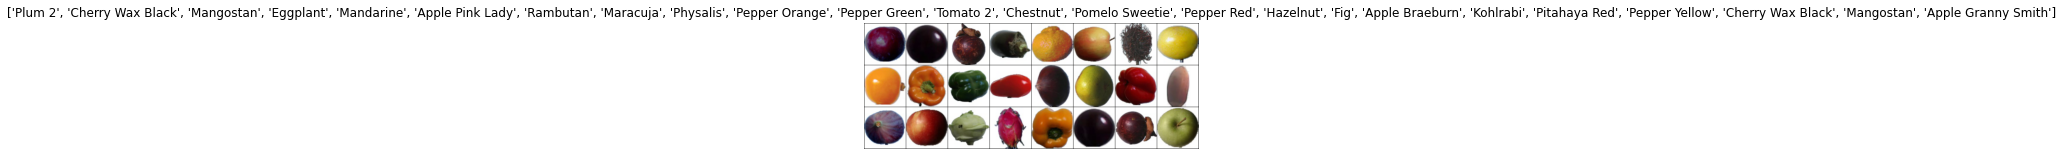

In [26]:
#helper function for visually referencing information
class_names = dataset[training_dataset].classes
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_batch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])
        
# Get a batch of training data
x, y = next(iter(dataloader[testing_dataset]))
show_batch(x, y)

In [27]:
#Checking the tensor shape of a single data image to ensure the correct format specified for the architecture
for images, labels in dataloader[training_dataset]:
    print(images.shape)
    break

torch.Size([24, 3, 224, 224])


In [28]:
#helper function to evaluate the model 
def eval_model(architecture, criteria_training):
        
    torch.cuda.empty_cache() #empty cuda cache to free memory
    starting_time = time.time()
    avg_loss = avg_acc = loss_test = acc_test = 0
    
    test_batches = len(dataloader[testing_dataset])
    print("Evaluating model")
    print('-' * 15)
    
    for index, data in enumerate(dataloader[testing_dataset]):
        if index % 5 == 0:
            print("\rTest batch of {}/{}".format(index, test_batches), end='', flush=True)

        architecture.train(False)
        architecture.eval()
        inputs, labels = data

        inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)

        outputs = architecture(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criteria_training(outputs, labels)

        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_lengths[testing_dataset]
    avg_acc = acc_test / dataset_lengths[testing_dataset]
    
    elapsed_time = time.time() - starting_time
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Average Loss (Testing): {:.3f}".format(avg_loss))
    print("Average Accuracy (Testing): {:.3f}".format(avg_acc))
    print('-' * 15)
    
    
#helper function to visually compare predictions with ground truth
def visualize_model(architecture, num_images):
    was_training = architecture.training
    
    # Set model for evaluation
    architecture.train(False)
    architecture.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloader[testing_dataset]):
        inputs, labels = data
        size = inputs.size()[0]
        
        inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        
        outputs = architecture(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_batch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_batch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    architecture.train(mode=was_training) # Revert model back to original training state

In [29]:
model = VGG_net()
model

VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

In [30]:
#moving the model to GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model.cuda()
    print("Device Type: CUDA\n\n")
    
#loss function
criteria = nn.CrossEntropyLoss()

#stochastic gradient descent optimizer
optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#Evaluating the model before training

print("Test before training")
eval_model(model, criteria)

Device Type: CUDA


Test before training
Evaluating model
---------------
Test batch of 945/946
Evaluation completed in 2m 2s
Average Loss (Testing): 0.203
Average Accuracy (Testing): 0.007
---------------


Ground truth:


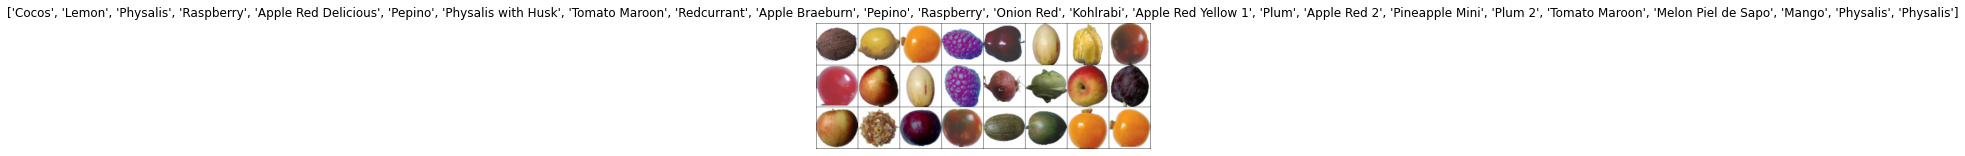

Prediction:


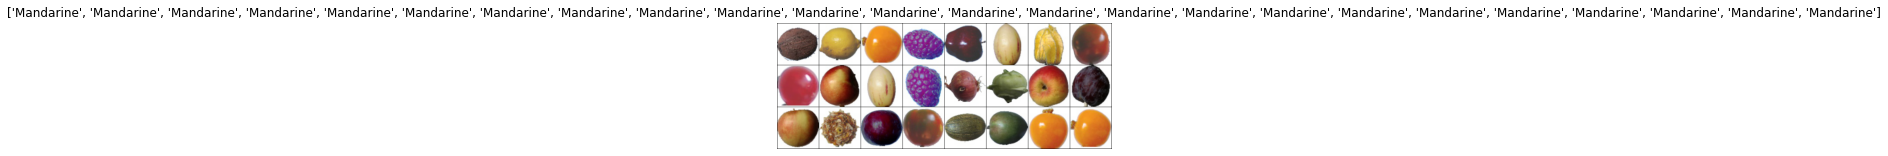

In [31]:
#predictions vs ground truth
visualize_model(model, 10)

In [32]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs):
    print("Training in progress:\n")
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = avg_acc = avg_loss_val = avg_acc_val = 0
    
    #loading dataset lengths for accuracy division
    train_batches = len(dataloader[training_dataset])
    val_batches = len(dataloader[testing_dataset])
    
    for epoch in range(num_epochs):
        print("Epoch of {}/{}".format(epoch+1, num_epochs))
        print('-' * 10)
        
        loss_train = loss_val = acc_train = acc_val = 0
        
        vgg.train(True)
        
        #trains the model
        for i, data in enumerate(dataloader[training_dataset]):
            if i % 10 == 0:
                print("\rTraining batch of {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break
                
            inputs, labels = data
            
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda()) #moving data to GPU
            
            optimizer.zero_grad() #refreshes the gradients for back propogation
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_lengths[training_dataset]
        avg_acc = acc_train * 2 / dataset_lengths[training_dataset]
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloader[testing_dataset]):
            if i % 10 == 0:
                print("\rValidation batch of {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_lengths[testing_dataset]
        avg_acc_val = acc_val / dataset_lengths[testing_dataset]
        
        print()
        print("Epoch {} result: ".format(epoch+1))
        print("Average Loss (Training): {:.5f}".format(avg_loss))
        print("Average Accuracy (Training): {:.5f}".format(avg_acc))
        print("Average Loss (Test): {:.5f}".format(avg_loss_val))
        print("Average Accuracy (Test): {:.5f}".format(avg_acc_val))
        print('-' * 15)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training Complete\nTraining completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best accuracy: {:.3f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

Training in progress:

Epoch of 1/10
----------
Training batch of 1410/1410.5
Validation batch of 940/946
Epoch 1 result: 
Average Loss (Training): 0.08935
Average Accuracy (Training): 0.44856
Average Loss (Test): 0.03632
Average Accuracy (Test): 0.76803
---------------

Epoch of 2/10
----------
Training batch of 1410/1410.5
Validation batch of 940/946
Epoch 2 result: 
Average Loss (Training): 0.01714
Average Accuracy (Training): 0.87417
Average Loss (Test): 0.01443
Average Accuracy (Test): 0.89796
---------------

Epoch of 3/10
----------
Training batch of 1410/1410.5
Validation batch of 940/946
Epoch 3 result: 
Average Loss (Training): 0.00663
Average Accuracy (Training): 0.95042
Average Loss (Test): 0.01196
Average Accuracy (Test): 0.92648
---------------

Epoch of 4/10
----------
Training batch of 1410/1410.5
Validation batch of 940/946
Epoch 4 result: 
Average Loss (Training): 0.00314
Average Accuracy (Training): 0.97746
Average Loss (Test): 0.00757
Average Accuracy (Test): 0.9579

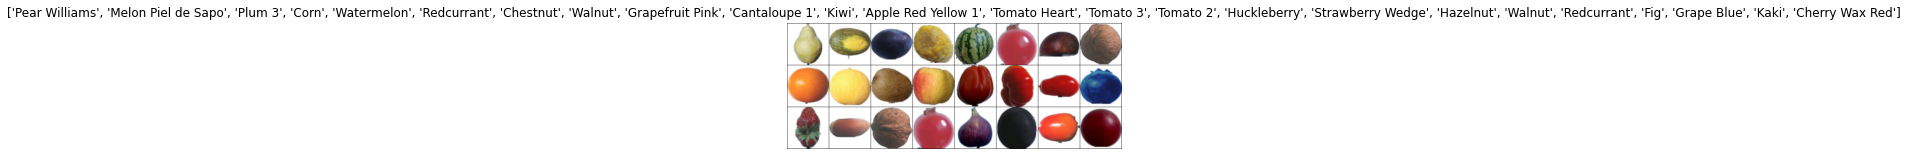

Prediction:


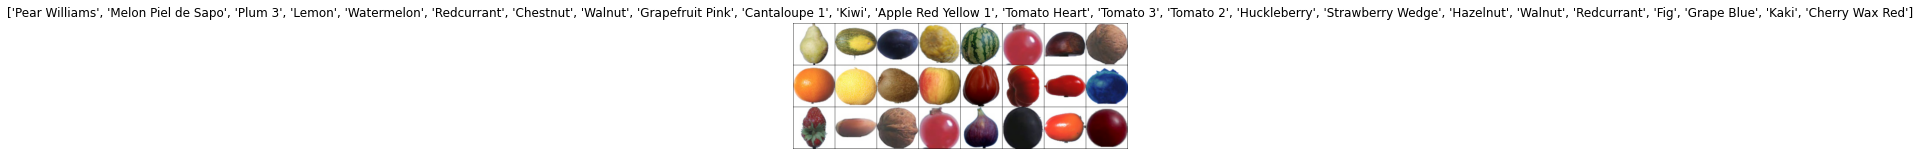

In [33]:
model = train_model(model, criteria, optimizer_ft, exp_lr_scheduler, num_epochs=10)
saved_model = torch.save(model.state_dict(), 'VGG_16_ML_Project.pt')
visualize_model(model, 10)

In [34]:
torch.save(model.state_dict(), 'checkpoint.pth')
state_dict = torch.load('checkpoint.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>